In [1]:

import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
import os
from tqdm import tqdm
import skimage

In [5]:
# data loading
data = []
path = "../data/datasets/train_set/"
classes = os.listdir(path)


def decode_img(img):
    # reading image from filepath
    I = skimage.io.imread(img)/255

    # check if it is in vertical orientatioon
    if I.shape[0] < I.shape[1]:
        I = I.T
    # add channel dim
    I = np.expand_dims(I, axis=-1)
    I = np.repeat(I, 3, axis=-1)
    # resize and return
    return tf.image.resize(I, [224, 224])

for i,class_name in tqdm(enumerate(classes)):
    files = os.listdir(path + class_name)
    class_images = np.load(f"../data/datasets/post_proccesed/{i}.npy")
    data.append(class_images)

21it [00:02,  8.04it/s]


In [ ]:

for i,class_name in tqdm(enumerate(classes)):
    files = os.listdir(path + class_name)
    class_images = np.zeros((len(files), 224, 224,3),dtype=np.float32)
    for j, file in enumerate(files):
        I = decode_img(path + class_name + "/" + file)
        class_images[j] = I
        
    #np.save(f"../data/datasets/post_proccesed/{i}.npy",class_images)
    data.append(class_images)

print("Done")

In [6]:
print(len(data))
total_lengths = np.zeros(len(data),dtype=np.int32)
print(total_lengths.shape)
for i,x in enumerate(data):
    #print(x.shape[0])
    total_lengths[i] = x.shape[0]

#print(total_lengths)


21
(21,)


In [7]:
# model
#from tensorflow.keras.applications import EfficientNetV2L
from tensorflow.keras import layers, Model, Input
width_shape = 224
height_shape = 224

image_input = Input(shape=(width_shape, height_shape, 3))
#model = EfficientNetV2L(input_tensor=image_input, include_top=False,weights='imagenet')


from vit_keras import vit

vit_model = vit.vit_b16(
        image_size = (224,224),
        activation = 'softmax',
        pretrained = True,
        include_top = True,
        pretrained_top = True,
        classes = 1000)

d = 768

vit_model_headless = vit_model.layers[-2].output 

c:\Users\kaczm\.conda\envs\tf2.8\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\kaczm\.conda\envs\tf2.8\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.10.0 and strictly below 2.13.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.8.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want 

Model: "vit-b16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 embedding (Conv2D)          (None, 14, 14, 768)       590592    
                                                                 
 reshape (Reshape)           (None, 196, 768)          0         
                                                                 
 class_token (ClassToken)    (None, 197, 768)          768       
                                                                 
 Transformer/posembed_input   (None, 197, 768)         151296    
 (AddPositionEmbs)                                               
                                                                 
 Transformer/encoderblock_0   ((None, 197, 768),       7087872   
 (TransformerBlock)           (None, 12, None, None))      

In [8]:
vit_model_headless = Model(inputs = vit_model.input, outputs = vit_model_headless)

In [9]:
start = 0
filename = "database.dat"
arr_shape = (np.sum(total_lengths),d)
arr = np.memmap(filename,
                    dtype='float32',
                    mode='w+',
                    shape=arr_shape)


for i in tqdm(range(len(data))):
    preds = vit_model_headless.predict(data[i])
    #preds = preds.reshape(total_lengths[i],preds.shape[1]*preds.shape[2]*preds.shape[3])

    print(preds.shape)

    stop = total_lengths[i] + start
    arr[start:stop] = preds
    start = stop
    
arr.flush(); del arr

  5%|▍         | 1/21 [00:07<02:34,  7.70s/it]

(580, 768)


 10%|▉         | 2/21 [00:10<01:36,  5.09s/it]

(556, 768)


 14%|█▍        | 3/21 [00:14<01:17,  4.31s/it]

(563, 768)


 19%|█▉        | 4/21 [00:17<01:07,  3.95s/it]

(566, 768)


 24%|██▍       | 5/21 [00:21<01:00,  3.76s/it]

(566, 768)


 29%|██▊       | 6/21 [00:24<00:55,  3.72s/it]

(618, 768)


 33%|███▎      | 7/21 [00:28<00:50,  3.59s/it]

(555, 768)


 38%|███▊      | 8/21 [00:31<00:45,  3.48s/it]

(551, 768)


 43%|████▎     | 9/21 [00:34<00:41,  3.42s/it]

(558, 768)


 48%|████▊     | 10/21 [00:37<00:36,  3.29s/it]

(503, 768)


 52%|█████▏    | 11/21 [00:40<00:30,  3.01s/it]

(400, 768)


 57%|█████▋    | 12/21 [00:42<00:24,  2.69s/it]

(295, 768)


 62%|██████▏   | 13/21 [00:45<00:23,  2.93s/it]

(592, 768)


 67%|██████▋   | 14/21 [00:48<00:21,  3.04s/it]

(551, 768)


 71%|███████▏  | 15/21 [00:52<00:18,  3.14s/it]

(565, 768)


 76%|███████▌  | 16/21 [00:55<00:16,  3.24s/it]

(577, 768)


 81%|████████  | 17/21 [00:59<00:13,  3.31s/it]

(584, 768)


 86%|████████▌ | 18/21 [01:02<00:09,  3.26s/it]

(529, 768)


 90%|█████████ | 19/21 [01:04<00:05,  2.99s/it]

(390, 768)


 95%|█████████▌| 20/21 [01:06<00:02,  2.76s/it]

(373, 768)


100%|██████████| 21/21 [01:09<00:00,  3.29s/it]

(377, 768)


In [11]:
#arr.flush(); del arr
    

In [10]:
def load_memmap_data(path, shape,
                     append_extra_length=None,
                     shape_only=False,
                     display=True):
    """
    Load data and datashape from the file path.

    • Get shape from [source_dir/fname_shape.npy}.
    • Load memmap data from [source_dir/fname.mm].

    Parameters
    ----------
    source_dir : (str)
    fname : (str)
        File name except extension.
    append_empty_length : None or (int)
        Length to appened empty vector when loading memmap. If activate, the
        file will be opened as 'r+' mode.
    shape_only : (bool), optional
        Return only shape. The default is False.
    display : (bool), optional
        The default is True.

    Returns
    -------
    (data, data_shape)

    """
    path_data = path
    
    data = np.memmap(path_data, dtype='float32', mode='r',
                         shape=(shape[0], shape[1]))
    if display:
        print(f'Load {shape[0]:,} items from \033[32m{path_data}\033[0m.')
    return data

In [11]:
filename = "database.dat"
emb = load_memmap_data(filename,(np.sum(total_lengths),d))

Load 10,849 items from database.dat.


In [13]:
import faiss

index = faiss.IndexFlatL2(d)   # build the index
index.add(emb)                  # add vectors to the index
print(index.is_trained)


k = 20                          # we want to see 4 nearest neighbors


True


(4, 224, 224, 3)


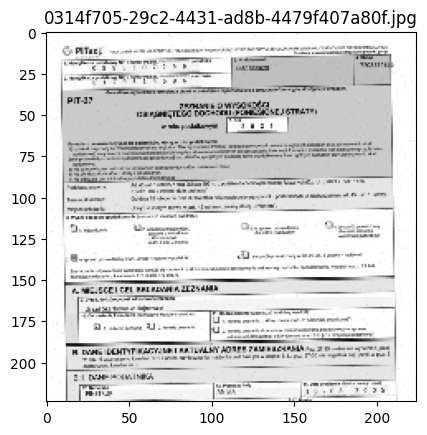

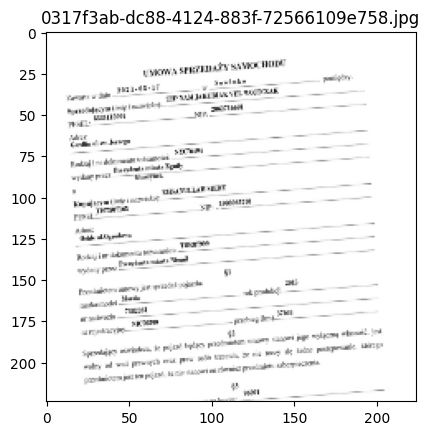

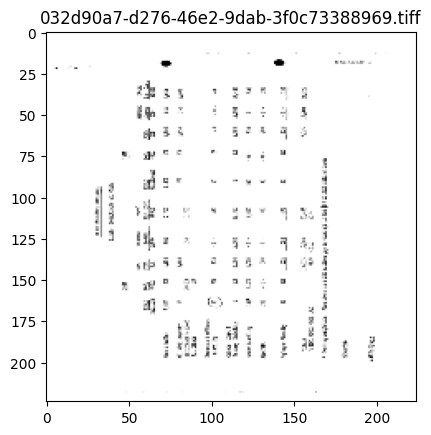

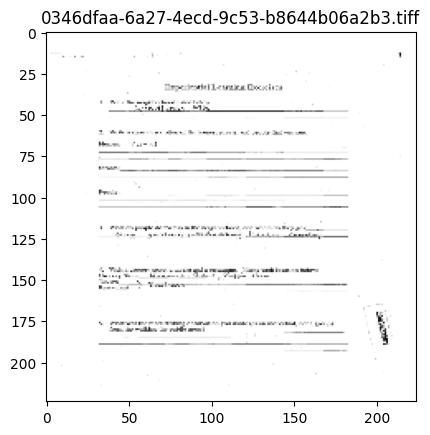

(4, 1000)


In [14]:
test_path = "../data/datasets/test_set/"
test_files = os.listdir(test_path)

examples= test_files[36:40]

test_data_arr = np.zeros((len(examples),224,224,3),dtype=np.float32)
print(test_data_arr.shape)
for i in range(len(examples)):
    new_data = decode_img(test_path+examples[i])
    test_data_arr[i] = new_data
    plt.imshow(test_data_arr[i])
    plt.title(examples[i])
    plt.show()
    plt.close()
test_preds = vit_model.predict(test_data_arr)
#test_preds = test_preds.reshape(test_preds.shape[0],d)
print(test_preds.shape)

In [17]:
D, I = index.search(test_preds, k) # sanity check

for i in range(len(examples)):
    plt.imshow(test_data_arr[i])
    plt.title(examples[i])
    plt.show()
    plt.close()

[[ 5929  5818  5952  5623  5919  5923  5852  5706  5936  5751  5880  5723
   5796  5888  5960  5718  5621  5637  5892  7008]
 [10566 10708 10461 10607 10159  9719 10215 10565 10153  6182  6040 10467
  10206 10556 10440 10771 10815 10194 10006 10276]
 [  853  6346   818  3983  3829  3993  9690  9013  1128  9032   608   990
   9911  6617  7952   904   905  9779  9859  3763]
 [10672 10081  6110  9723  4817 10768 10683 10542 10678  6185  9291  6167
    739 10491   794 10636 10731  1559 10676  6058]]


In [ ]:
start = 0
IDX_arr = np.zeros((len(classes),3),dtype=np.int32)
print(IDX_arr.shape)
for i in range(len(data)):
    
    stop = total_lengths[i] + start
    IDX_arr[i,:] = np.array([start,stop,i])
    start = stop
    
 

with open("output.txt", "w") as f:
    f.write(str(IDX_arr))

 


(21, 3)
